# Implement AdaBoost

# 1. read data

In [1]:
# import function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import time
import math
import random
%matplotlib inline

In [2]:
SampleData_SavePath = "./data/A1.csv"

SampleData_pd = pd.DataFrame()
if not os.path.isfile(SampleData_SavePath):
    print(SampleData_SavePath, "is not existed.")
else :
    print(SampleData_SavePath, "is existed.")
    SampleData_pd = pd.read_csv(SampleData_SavePath)

print(SampleData_pd)
print(SampleData_pd.dtypes)

def preprocessLabel(label):
    if label == -1 :
        return 0
    else:
        return 1

SampleData_pd['label'] = SampleData_pd.apply(lambda x :preprocessLabel(x['label']), axis = 1)
print(SampleData_pd)

./data/A1.csv is existed.
   number    x    y  label
0       1   80  144      1
1       2   93  232      1
2       3  136  275     -1
3       4  147  131     -1
4       5  159   69      1
5       6  214   31      1
6       7  214  152     -1
7       8  257   83      1
8       9  307   62     -1
9      10  307  231     -1
number    int64
x         int64
y         int64
label     int64
dtype: object
   number    x    y  label
0       1   80  144      1
1       2   93  232      1
2       3  136  275      0
3       4  147  131      0
4       5  159   69      1
5       6  214   31      1
6       7  214  152      0
7       8  257   83      1
8       9  307   62      0
9      10  307  231      0


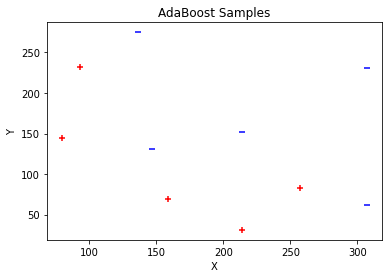

In [3]:
# display data
plt.title("AdaBoost Samples")
plt.xlabel('X')
plt.ylabel('Y')

for index, row in SampleData_pd.iterrows():
    if row['label'] == 1:
        plt.scatter(row['x'], row['y'], marker='+', color='red')
    else:
        plt.scatter(row['x'], row['y'], marker='_', color='blue')
plt.savefig("./pictures/samples.jpg")
plt.show()

In [9]:
# 先不要打乱，并将标签与数据分割出来。
# 分割的作用是方便与后面进行错误率的计算。这样混合在一起的数据集、单纯数据集、标签集都有了。
# Samples = SampleData_pd.sample(frac=1).copy()

Samples_data = Samples.iloc[:,:3].copy()
Labels_data = Samples.iloc[:,3].copy()

print(Samples)
print(Labels_data)
print(Labels_data.shape)

   number    x    y  label
0       1   80  144      1
6       7  214  152      0
1       2   93  232      1
7       8  257   83      1
5       6  214   31      1
9      10  307  231      0
3       4  147  131      0
2       3  136  275      0
8       9  307   62      0
4       5  159   69      1
0    1
6    0
1    1
7    1
5    1
9    0
3    0
2    0
8    0
4    1
Name: label, dtype: int64
(10,)


# 2. complete train weak classifier

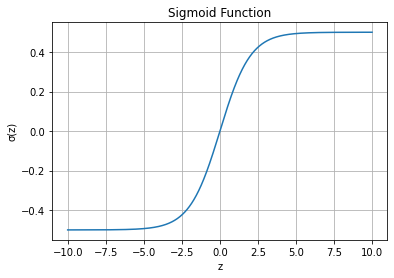

In [8]:
# common function
# activtion function 
def sigmoid(input):
    return (1.0/(1 + np.exp(-input)))-0.5

# display and survey/check/test sigmoid function
z = np.arange(-10, 10, 0.01)
fz = []
for zi in z:
    fz.append(sigmoid(zi))
plt.title('Sigmoid Function')
plt.xlabel('z')
plt.ylabel('σ(z)')
plt.plot(z, fz)
plt.grid()
plt.savefig("./pictures/sigmoid.jpg")
plt.show()

In [24]:
def displaySingleWeakClassifier(wc_type, samples, theta, error_rate, offset=10):
    plt.title("AdaBoost Weak Classifier")
    plt.xlabel('X')
    plt.ylabel('Y')

    for index, row in samples.iterrows():
        if row['label'] == 1:
            plt.scatter(row['x'], row['y'], marker='+', color='red')
        else:
            plt.scatter(row['x'], row['y'], marker='_', color='blue')
    if wc_type == 'x':
        plt.axvline(theta)
        y_mean = samples['y'].mean()
        plt.text(theta + offset/2, y_mean, 'error rate =%0.2f'%error_rate)
    else:
        plt.axhline(theta)
        x_mean = samples['x'].mean()
        # 加了一个偏移量，避免显示的字和线条重合在一起。
        plt.text(x_mean, theta + offset, 'error rate =%0.2f'%error_rate)
    plt.show()

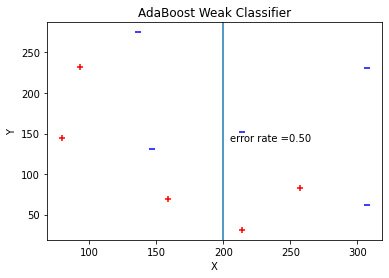

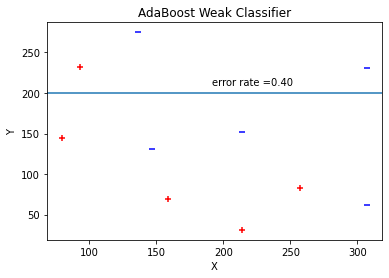

In [26]:
# 测试显示弱分类器的函数。
displaySingleWeakClassifier('x', SampleData_pd, 200, 0.5)

displaySingleWeakClassifier('y', SampleData_pd, 200, 0.4)

In [27]:
# def displayMultipleWeakClassifier(wc_type_list, samples, theta_list, error_rate_list, offset=10):
#     plt.title("AdaBoost Weak Classifier")
#     plt.xlabel('X')
#     plt.ylabel('Y')

#     for index, row in samples.iterrows():
#         if row['label'] == 1:
#             plt.scatter(row['x'], row['y'], marker='+', color='red')
#         else:
#             plt.scatter(row['x'], row['y'], marker='_', color='blue')
#     if wc_type == 'x':
#         plt.axvline(theta)
#         y_mean = samples['y'].mean()
#         plt.text(theta + offset/2, y_mean, 'error rate =%0.2f'%error_rate)
#     else:
#         plt.axhline(theta)
#         x_mean = samples['x'].mean()
#         # 加了一个偏移量，避免显示的字和线条重合在一起。
#         plt.text(x_mean, theta + offset, 'error rate =%0.2f'%error_rate)
#     plt.show()

In [14]:
# 测试更新样本权重函数。
temp = Labels_data.copy()
temp[6] = 1
temp[2] = 1
print(temp)
print(temp.shape[0])

def update_sample_weight(samples_weight_before, wc_weight, labels, prediction):
    # 更新样本的权重。
    new_samples_weight = []
    for i in range(len(labels)):
        new_samples_weight.append(samples_weight_before[i] * np.exp(-wc_weight * labels[i] * prediction[i]))
        pass
    return np.array(new_samples_weight/sum(new_samples_weight)).reshape([len(labels) ,1])
samples_weight_before = [(1.0/(SampleData_pd.shape[0])) for i in range(Samples_data.shape[0])]
wc_weight = 0.8
print(update_sample_weight(samples_weight_before, wc_weight, Labels_data, temp))

def compare(a, b):
    if a == b:
        return 1
    else:
        return 0

def calculate_Error_rate(labels, pred, sample_weight):
    # 计算弱分类器的错误率。
    temp_pd = pd.concat([labels, pred], axis=1)
    # temp_pd['ret'] = temp_pd.apply(lambda x : compare(temp_pd['label'], temp_pd['pred']), axis=1)
    ret = 0
    for i in range(labels.shape[0]):
        if labels[i] != pred[i]:
            ret += sample_weight[i]
    return ret

0    1
6    1
1    1
7    1
5    1
9    0
3    0
2    1
8    0
4    1
Name: label, dtype: int64
10
[[0.0620051]
 [0.0620051]
 [0.1379949]
 [0.1379949]
 [0.0620051]
 [0.0620051]
 [0.1379949]
 [0.0620051]
 [0.1379949]
 [0.1379949]]


In [34]:
def WeakClassifier(input, theta):
    temp = sigmoid((input - theta))
    if temp >= 0:
        Predict_Label = 0
    else:
        Predict_Label = 1
    return Predict_Label

class FindSingleWeakClassifier:
    """[summary]
    最终是需要输出一个弱分类器的形式。所以中间对数据集都以list的形式来处理。
    Returns:
        [type]: [description]
    """
    # step_size, 
    def __init__(self, wc_function, samples, labels, samples_weight, wc_type, step_number=0):
        """[summary]

        Args:
            wc_function ([function pointer]): [define weak classifier function form.]
            samples ([pd.DataFrame]): [samples data]
            labels ([pd.DataFrame]): [labels data]
            step_size ([float]): [step size]
            step_number ([float]): [step number]
            wc_type ([int:0|1]): [weak classifier type. in this example, 
                                    it means x or y.]
        """
        self.wc_function = wc_function
        # 这里不对，直接按照x或者y的类型，来计算对比的方向。
        # self.samples = samples
        self.labels = labels.tolist()
        self.wc_type = wc_type
        self.samples_weight = samples_weight
        
        # calculate step size and input samples.
        if self.wc_type == 'x':
            self.samples = samples['x'].tolist()
            xMax = max(self.samples)
            xMin = min(self.samples)
            if step_number == 0:
                # calculate weakclassifier step if no step_number is inputted.
                self.step_number = samples.shape[0]
            self.StepSize = (xMax - xMin) / self.step_number
        else:
            self.samples = samples['y'].tolist()
            yMax = max(self.samples)
            yMin = min(self.samples)
            if step_number == 0:
                # calculate weakclassifier step if no step_number is inputted.
                self.step_number = samples.shape[0]
            self.StepSize = (yMax - yMin) / self.step_number
            
        
    def predictSamples(self, theta):
        # prediction = pd.DataFrame(np.zeros((10,1)))
        # for index, row in self.samples.iterrows():
        #     self.wc_function(row, theta)
        prediction = [0 for i in range(len(self.samples))]
        for i in range(len(self.samples)):
            prediction[i] = self.wc_function(self.samples[i], theta)
        return prediction
    
    def calculate_Error_rate(self, labels, pred, sample_weight):
        # 计算弱分类器的错误率。
        ret = 0
        for i in range(len(labels)):
            if labels[i] != pred[i]:
                ret += sample_weight[i]
        return ret
    
    # def update_sample_weight(self, old_samples_weight, wc_weight, labels, prediction):
    #     # 更新样本的权重。
    #     new_samples_weight = []
    #     for i in range(len(labels)):
    #         new_samples_weight.append(old_samples_weight[i] * np.exp(-wc_weight * labels[i] * prediction[i]))
    #         pass
    #     return np.array(new_samples_weight/sum(new_samples_weight)).reshape([len(labels) ,1])
    
    def FindSingleWeakClassifier(self):
        temp_theta = []
        temp_error_rate = []
        temp_prediction = []
        # 初始时，样本的权重是平均值。
        # init_samples_weight = [(1.0/(self.samples.shape[0])) for i in range(self.samples.shape[0])]
        
        for i in range(self.step_number):
            # 按照步长来训练弱分类器。
            theta = i * self.StepSize
            temp_theta.append(theta)
            temp_prediction = self.predictSamples(theta)
            temp_error_rate.append(self.calculate_Error_rate(self.labels, temp_prediction, self.samples_weight))
        location = temp_error_rate.index(min(temp_error_rate))
        return temp_theta[location], temp_error_rate[location]


113.5


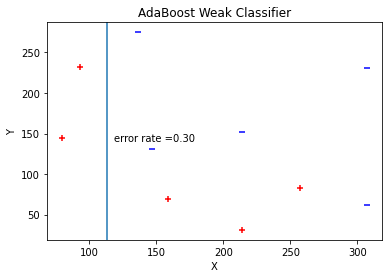

In [35]:
samples_weight = [(1.0/(Samples_data.shape[0])) for i in range(Samples_data.shape[0])]

getWCClass = FindSingleWeakClassifier(WeakClassifier, Samples_data, Labels_data, samples_weight, 'x')
theta, error_rate = getWCClass.FindSingleWeakClassifier()
print(theta)
displaySingleWeakClassifier('x', SampleData_pd, theta, error_rate)